In [1]:
!pip install lightgbm

In [2]:
#!pip install --upgrade scikit-learn==1.4.0
#!pip show scikit-learn

In [3]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE

In [4]:
!pip show joblib

Name: joblib
Version: 1.3.2
Summary: Lightweight pipelining with Python functions
Home-page: 
Author: 
Author-email: Gael Varoquaux <gael.varoquaux@normalesup.org>
License: BSD 3-Clause
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: cesium, cleverhans, contextily, cuml, fitter, gplearn, imbalanced-learn, kmodes, librosa, mlxtend, nilearn, phik, pyLDAvis, pynndescent, raft-dask, rgf-python, scikit-learn, scikit-optimize, scikit-plot, scikit-surprise, segregation, tobler, TPOT


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#from collections import Counter
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from sklearn import metrics
#from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
# xgboost для классификации
#from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from joblib import dump
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [6]:
path = '/kaggle/input/ptb-xl-a-large-publicly-available2/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

scp_data = pd.read_csv(path + 'scp_statements.csv')


In [7]:
path = '/kaggle/input/electrocardiogram-database-for-arrhythmia-study/ecg_df_diagnostic.csv'

ecg_df_HTV = pd.read_csv(path, index_col=0 )


In [8]:
len(ecg_df_HTV.columns[:-6])/12

37.75

In [9]:
def sort_by_diagnostic(name_column):
    list_diagnostic = []
    for i in ecg_df_HTV["diagnostic"].index:
        k = ecg_df_HTV["diagnostic"][i].split(",")
        if len(k) > 1:
            k.sort()
            for i in range(0,len(k)):
                for j in range(0,len(scp_data[scp_data.diagnostic ==1 ])):
                    if (scp_data[scp_data.diagnostic ==1 ]["Unnamed: 0"][j]) == k[i] : 
                        k[i] = scp_data[scp_data.diagnostic ==1 ][name_column][j]
            k.sort()
            k = list(dict.fromkeys(k))
        k = ",".join(k)
        list_diagnostic.append(k)
    return  list_diagnostic
#ecg_df_HTV["diagnostic_2"] = sort_by_diagnostic("diagnostic_subclass")

In [10]:
ecg_df_HTV["diagnostic"].value_counts()[:20]

diagnostic
NORM          9025
LVH           2505
LAFB          2434
CRBBB         2092
LAO/LAE       2010
1AVB          2010
NST_          1972
CLBBB         1278
NDT           1154
IMI           1121
RVH           1017
IRBBB          926
ISCAL          594
ISC_,LVH       521
LPFB           412
ILBBB          386
ASMI           357
ISCLA          319
RAO/RAE        262
IRBBB,NORM     242
Name: count, dtype: int64

In [11]:
for i in ecg_df_HTV["diagnostic"].index:
    if ((len(ecg_df_HTV["diagnostic"][i].split(","))) > 1) & ("NORM" in ecg_df_HTV["diagnostic"][i]) :
        k = ecg_df_HTV["diagnostic"][i].split(",")
        k.remove("NORM")
        k.sort()
        k = ",".join(k)
        ecg_df_HTV["diagnostic"] = ecg_df_HTV["diagnostic"].replace([ecg_df_HTV["diagnostic"][i]],k)

Norm+

In [12]:
ecg_df_HTV = ecg_df_HTV.loc[ecg_df_HTV['diagnostic'] != ""]

In [13]:
df = ecg_df_HTV.copy()
for i in ecg_df_HTV["diagnostic"].value_counts().index:
    if len(i.split(",")) > 2:
        df = df.loc[df["diagnostic"] != i]

In [14]:
df["diagnostic"].value_counts()[:20]

diagnostic
NORM        9025
LVH         2506
LAFB        2451
CRBBB       2092
1AVB        2045
LAO/LAE     2010
NST_        1972
CLBBB       1278
IRBBB       1168
NDT         1154
IMI         1121
RVH         1017
ISCAL        594
ISC_,LVH     521
LPFB         419
ILBBB        386
ASMI         357
ISCLA        319
RAO/RAE      263
IVCD         250
Name: count, dtype: int64

In [15]:
ecg_df_HTV["diagnostic"].value_counts()[:20]

diagnostic
NORM        9025
LVH         2506
LAFB        2451
CRBBB       2092
1AVB        2045
LAO/LAE     2010
NST_        1972
CLBBB       1278
IRBBB       1168
NDT         1154
IMI         1121
RVH         1017
ISCAL        594
ISC_,LVH     521
LPFB         419
ILBBB        386
ASMI         357
ISCLA        319
RAO/RAE      263
IVCD         250
Name: count, dtype: int64

In [16]:
import random

In [17]:
def Entering_missing_values(df,name):
    df_numeric = ecg_df_HTV.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    for i in df[name].value_counts().index[:25]:
        df_1 = df[df[name] == i]
        for col in numeric_cols:
            if (np.mean(df_1[col].isnull()) > 0) and (np.mean(df_1[col].isnull()) < 1):
                df_1[col] = df_1[col].fillna(df_1[col].median())                        
        df[df[name] == i] = df_1
    return df

In [18]:
ecg_df_HTV = Entering_missing_values(ecg_df_HTV,"diagnostic")

Информативность

In [19]:
num_rows = len(ecg_df_HTV.index)
low_information_cols = [] #

for col in ecg_df_HTV.columns:
    cnts = ecg_df_HTV[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.40:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))

0_VLF_Peak (Hz): 94.32928%
0_LF_Peak (Hz): 86.06528%
1_VLF_Peak (Hz): 94.12894%
1_LF_Peak (Hz): 85.63399%
2_VLF_Peak (Hz): 93.33315%
2_LF_Peak (Hz): 84.66290%
3_VLF_Peak (Hz): 93.39993%
3_LF_Peak (Hz): 85.31957%
4_VLF_Peak (Hz): 93.64757%
4_LF_Peak (Hz): 84.81594%
5_VLF_Peak (Hz): 93.86460%
5_LF_Peak (Hz): 85.25279%
6_VLF_Peak (Hz): 94.14842%
6_LF_Peak (Hz): 85.85659%
7_VLF_Peak (Hz): 94.29033%
7_LF_Peak (Hz): 86.14875%
8_VLF_Peak (Hz): 94.26807%
8_LF_Peak (Hz): 86.20997%
9_VLF_Peak (Hz): 94.51014%
9_LF_Peak (Hz): 86.73864%
10_VLF_Peak (Hz): 94.57970%
10_LF_Peak (Hz): 86.73029%
11_VLF_Peak (Hz): 94.47119%
11_LF_Peak (Hz): 86.79151%
sex: 72.38098%


In [20]:
def srez_df(ecg_df_HTV,name_column,count_v,count_n):
    df = pd.DataFrame()
    for i in ecg_df_HTV[name_column].value_counts()[0:count_v].index:
         df = pd.concat([
            df,
            ecg_df_HTV[ecg_df_HTV[name_column] == i][:count_n]]
        )
    return  df

In [21]:
ecg_df_HTV["diagnostic"].value_counts()[:15]

diagnostic
NORM        9025
LVH         2506
LAFB        2451
CRBBB       2092
1AVB        2045
LAO/LAE     2010
NST_        1972
CLBBB       1278
IRBBB       1168
NDT         1154
IMI         1121
RVH         1017
ISCAL        594
ISC_,LVH     521
LPFB         419
Name: count, dtype: int64

In [22]:
ecg_df_HTV = ecg_df_HTV.dropna()

In [23]:
ecg_df_HTV_diagnostic_n = srez_df(ecg_df_HTV,"diagnostic",15,20000)
ecg_df_HTV_diagnostic_n.index = pd.RangeIndex(start=0, stop=len(ecg_df_HTV_diagnostic_n))


In [24]:
ecg_df_HTV

,0_Mean RR (ms),0_STD RR/SDNN (ms),0_Mean HR (Kubios' style) (beats/min),0_Mean HR (beats/min),0_STD HR (beats/min),0_Min HR (beats/min),0_Max HR (beats/min),0_RMSSD (ms),0_NNxx,0_pNNxx (%),...,11_Min_P,11_Max_Q,11_Min_Q,11_Max_S,11_Min_S,11_Max_T,11_Min_T,age,sex,diagnostic
0,0.294714,1.857784,-0.448129,-0.339019,1.224009,-0.985329,0.333438,1.636349,0.698073,1.070923,...,0.361770,0.032676,0.531560,-0.868957,-0.188904,-0.414058,-0.374480,0.397948,-0.666883,CRBBB
1,-0.605783,-0.025090,0.373440,0.335230,0.010474,0.253886,0.160776,-0.098543,0.983463,0.699654,...,0.534591,-0.098155,0.298308,-0.951303,-0.275921,3.169181,-0.231698,-0.081682,-0.666883,CRBBB
2,-0.153063,-0.561229,-0.083994,-0.126195,-0.530526,0.203470,-0.348168,-0.520452,-0.728876,-0.859674,...,0.044933,-0.359817,-0.148760,-0.292535,-0.000366,0.039331,-0.326886,0.136332,-0.666883,CRBBB
3,0.388922,-0.576440,-0.515920,-0.547819,-0.558183,-0.254884,-0.669709,-0.528545,-1.014266,-1.156689,...,0.390574,-0.464482,0.239995,-0.374881,0.347704,-0.253178,-0.231698,0.136332,-0.666883,CRBBB
4,0.491271,-0.590281,-0.586560,-0.616799,-0.568887,-0.331226,-0.720878,-0.507999,-0.728876,-0.785421,...,0.044933,-0.255152,0.239995,-0.292535,-0.000366,-0.019170,0.244242,0.136332,-0.666883,CRBBB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35934,1.832276,-0.345388,-1.294939,-1.307278,-0.495041,-1.129730,-1.192945,-0.335587,-0.728876,-0.414152,...,-0.081802,-0.302251,0.138919,0.164485,0.544944,3.318360,-0.436352,1.051989,-0.666883,1AVB
35935,1.192761,-0.575469,-1.000112,-1.020355,-0.572502,-0.779761,-1.016936,-0.493811,-0.728876,-0.573267,...,0.281121,-0.302251,0.344958,-1.441262,-0.600787,-0.124474,0.701145,0.485154,1.499483,1AVB
35936,1.054627,-0.579601,-0.927215,-0.949222,-0.572380,-0.698416,-0.962449,-0.494633,-0.443486,-0.274926,...,-1.435563,-0.197587,-0.545289,-0.337826,-0.104787,-0.095223,-0.226939,0.179935,-0.666883,1AVB
35937,0.724900,1.468744,-0.737068,-0.679312,0.819327,-1.198591,0.199772,1.796872,0.127293,0.560428,...,0.027651,-1.448330,-0.961256,0.185071,0.176570,-0.238552,-0.598172,0.964784,-0.666883,1AVB


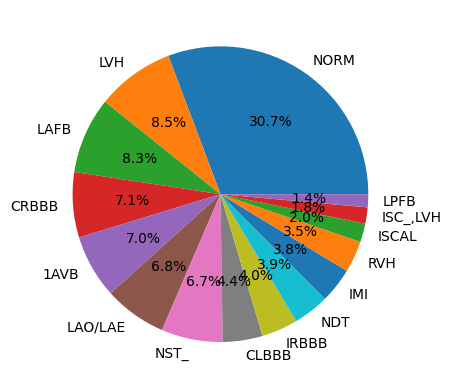

In [25]:
import matplotlib.pyplot as plt
# Круговая диаграмма, секторы которой будут упорядочены и расположены против часовой стрелки:
labels = ecg_df_HTV_diagnostic_n.diagnostic.value_counts().index
sizes = list(ecg_df_HTV_diagnostic_n.diagnostic.value_counts())
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')#autopct='%1.1f%%'
plt.show()

In [26]:
ecg_df_HTV_diagnostic_n["diagnostic"],uniques_diagnostic = pd.factorize(ecg_df_HTV_diagnostic_n.diagnostic)
ecg_df_HTV_diagnostic= ecg_df_HTV_diagnostic_n.dropna()
ecg_df_HTV_diagnostic.index = pd.RangeIndex(start=0, stop=len(ecg_df_HTV_diagnostic))


In [27]:
ecg_df_HTV_diagnostic.diagnostic.value_counts()

diagnostic
0     9025
1     2506
2     2451
3     2092
4     2045
5     2010
6     1972
7     1278
8     1168
9     1154
10    1121
11    1017
12     594
13     521
14     419
Name: count, dtype: int64

In [28]:
#ecg_df_HTV_diagnostic_n["diagnostic"],uniques_diagnostic = pd.factorize(ecg_df_HTV_diagnostic_n.diagnostic)
ecg_df_HTV_diagnostic= ecg_df_HTV_diagnostic_n.dropna()

In [29]:
pd.DataFrame(uniques_diagnostic)

,0
0,NORM
1,LVH
2,LAFB
3,CRBBB
4,1AVB
5,LAO/LAE
6,NST_
7,CLBBB
8,IRBBB
9,NDT


In [30]:
df_numeric = ecg_df_HTV_diagnostic.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

In [31]:
df_corr_diagnostic_class_n =ecg_df_HTV_diagnostic[numeric_cols].corr(method='spearman')[["diagnostic"]] #,"diagnostic"

In [32]:
#ecg_df_HTV_new = ecg_df_HTV_new.dropna(thresh=260).dropna(axis=1)

In [33]:
def func_corr_a(name,df_corr_diagnostic,N):
    param = df_corr_diagnostic[((df_corr_diagnostic[name] > N)|(df_corr_diagnostic[name] < -N))&(df_corr_diagnostic[name] != 1)  ]
    list_corr_=[]
    for i in list(param.index):
        if '_' in i :
            if (i[i.index('_')+1:] in list_corr_) != True:
                list_corr_.append(i)
                list_corr_.append(i[i.index('_')+1:])
                list_corr_.append(param[name][i])
            else :
                if abs(list_corr_[list_corr_.index(i[i.index('_')+1:])+1]) < abs(param[name][i] ):
                    list_corr_[list_corr_.index(i[i.index('_')+1:])-1] = i   
                    list_corr_[list_corr_.index(i[i.index('_')+1:])+1] = param[name][i]
        else : 
            list_corr_.append(i)
            list_corr_.append(i)
            list_corr_.append(param[name][i])
    return list_corr_

In [34]:
list_corr_diagnostic=func_corr_a("diagnostic",df_corr_diagnostic_class_n,0.01)
list_corr_diagnostic[::3]

['10_Mean RR (ms)',
 '8_STD RR/SDNN (ms)',
 "10_Mean HR (Kubios' style) (beats/min)",
 '10_Mean HR (beats/min)',
 '8_STD HR (beats/min)',
 '0_Min HR (beats/min)',
 '10_Max HR (beats/min)',
 '8_RMSSD (ms)',
 '8_NNxx',
 '8_pNNxx (%)',
 '11_VLF_Peak (Hz)',
 '10_LF_Peak (Hz)',
 '0_VLF_Abs (ms2)',
 '0_LF_Abs (ms2)',
 '0_HV_Abs (ms2)',
 '4_VLF_Rel (%)',
 '11_LF_Rel (%)',
 '0_VLF_Log (-)',
 '0_LF_Log (-)',
 '0_HV_Log (-)',
 '0_Total Power (ms)',
 '9_Max_R',
 '9_Min_R',
 '0_Max_RR',
 '10_Min_RR',
 '3_Max_P',
 '9_Min_P',
 '6_Max_Q',
 '8_Min_Q',
 '0_Max_S',
 '0_Min_S',
 '10_Max_T',
 '10_Min_T',
 '11_LF_Norm (-)',
 '11_HV_Norm (-)',
 '11_LF/HF (-)',
 '3_HV_Peak (Hz)',
 '3_HV_Rel (%)',
 'age',
 'sex']

In [35]:
wew_twe = list_corr_diagnostic[::3].copy()[:-2]
wew = []
A = " отведение "
for i in range(len(wew_twe)):
    wew.append([int(wew_twe[i].split("_")[0])+1,list_corr_diagnostic[1::3][i]])
wew.sort()

In [36]:
for i in pd.DataFrame(wew).index:
    print(pd.DataFrame(wew)[0][i],A,pd.DataFrame(wew)[1][i])

1  отведение  HV_Abs (ms2)
1  отведение  HV_Log (-)
1  отведение  LF_Abs (ms2)
1  отведение  LF_Log (-)
1  отведение  Max_RR
1  отведение  Max_S
1  отведение  Min HR (beats/min)
1  отведение  Min_S
1  отведение  Total Power (ms)
1  отведение  VLF_Abs (ms2)
1  отведение  VLF_Log (-)
4  отведение  HV_Peak (Hz)
4  отведение  HV_Rel (%)
4  отведение  Max_P
5  отведение  VLF_Rel (%)
7  отведение  Max_Q
9  отведение  Min_Q
9  отведение  NNxx
9  отведение  RMSSD (ms)
9  отведение  STD HR (beats/min)
9  отведение  STD RR/SDNN (ms)
9  отведение  pNNxx (%)
10  отведение  Max_R
10  отведение  Min_P
10  отведение  Min_R
11  отведение  LF_Peak (Hz)
11  отведение  Max HR (beats/min)
11  отведение  Max_T
11  отведение  Mean HR (Kubios' style) (beats/min)
11  отведение  Mean HR (beats/min)
11  отведение  Mean RR (ms)
11  отведение  Min_RR
11  отведение  Min_T
12  отведение  HV_Norm (-)
12  отведение  LF/HF (-)
12  отведение  LF_Norm (-)
12  отведение  LF_Rel (%)
12  отведение  VLF_Peak (Hz)


Z

In [37]:
def stardant(X_columns):
    #определяем смещение Центрируем данные относительно 0
    fix_displacement_min = X_columns.describe()
    for i in X_columns.describe().columns:   
        X_columns[i] = X_columns[i] - fix_displacement_min[i]["min"]
    fix_displacement = X_columns.describe()
    #Стандартизация по z-оценке
    for i in X_columns.describe().columns:   
        X_columns[i] = (X_columns[i] - fix_displacement[i]["mean"])/(fix_displacement[i]["std"])
    return X_columns ,fix_displacement_min,fix_displacement#

male 0, female 1

## diagnostic

In [38]:
ecg_df_HTV_diagnostic_n_new = ecg_df_HTV_diagnostic.copy()

In [39]:
df_numeric = ecg_df_HTV_diagnostic.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

In [40]:
df_test = ecg_df_HTV_diagnostic_n_new.dropna().copy()[numeric_cols]
df_new = ecg_df_HTV_diagnostic_n_new.dropna().copy()[numeric_cols]

In [165]:
n = 3000
df_new =df_test[df_test.diagnostic == df_test.diagnostic.value_counts().index[0]][:n ].copy()
for i in df_test.diagnostic.value_counts().index[1:]:
    df_new = pd.concat([df_new, df_test[df_test.diagnostic == i][:n ]], ignore_index=True)

In [170]:
#X_diagnostic, y_diagnostic  = df_new[df_new.columns[:-1]], df_new['diagnostic']
X_diagnostic, y_diagnostic  = df_new[list_corr_diagnostic[::3]], df_new['diagnostic']
list_corr_diagnostic[::3]
y_diagnostic= y_diagnostic.astype('int')
df_new['diagnostic'].value_counts()

diagnostic
0     3000
1     2506
2     2451
3     2092
4     2045
5     2010
6     1972
7     1278
8     1168
9     1154
10    1121
11    1017
12     594
13     521
14     419
Name: count, dtype: int64

In [84]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [172]:
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X_diagnostic, y_diagnostic = sm.fit_resample(X_diagnostic, y_diagnostic)
sm = BorderlineSMOTE(random_state=42)
X_diagnostic, y_diagnostic = sm.fit_resample(X_diagnostic, y_diagnostic)

In [173]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diagnostic, y_diagnostic, test_size=0.1, random_state=0)

## LGBMClassifier

In [47]:
from sklearn.metrics import f1_score,accuracy_score,balanced_accuracy_score

In [48]:
from sklearn.metrics import classification_report

In [74]:
model_LGBMClassifier = LGBMClassifier(random_seed=7575)
model_LGBMClassifier.fit(X_train, y_train)
print("score ",model_LGBMClassifier.score(X_train, y_train))
y_predict = model_LGBMClassifier.predict(X_valid)
print("f1_score micro ",f1_score(y_valid,y_predict, average='micro')) #"samples"
print("f1_score macro ",f1_score(y_valid,y_predict, average='macro'))
print("f1_score weighted ",f1_score(y_valid,y_predict, average='weighted'))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9981
[LightGBM] [Info] Number of data points in the train set: 40567, number of used features: 40
[LightGBM] [Info] Start training from score -2.703059
[LightGBM] [Info] Start training from score -2.714530
[LightGBM] [Info] Start training from score -2.710815
[LightGBM] [Info] Start training from score -2.718258
[LightGBM] [Info] Start training from score -2.709333
[LightGBM] [Info] Start training from score -2.705269
[LightGBM] [Info] Start training from score -2.708593
[LightGBM] [Info] Start training from score -2.708223
[LightGBM] [Info] Start training from score -2.708223
[LightGBM] [Info] Start training from score -2.707114
[LightGBM] [Info] Start training from score -2.705637
[LightGBM] [Info] Start training from

In [75]:
accuracy_score(y_valid, y_predict),balanced_accuracy_score(y_valid, y_predict)

(0.8524844720496895, 0.8529672154495437)

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68       287
           1       0.83      0.74      0.78       318
           2       0.75      0.70      0.72       308
           3       0.90      0.88      0.89       328
           4       0.89      0.84      0.86       304
           5       0.87      0.90      0.88       293
           6       0.89      0.89      0.89       302
           7       0.84      0.84      0.84       301
           8       0.87      0.84      0.85       301
           9       0.93      0.93      0.93       298
          10       0.72      0.76      0.74       294
          11       0.90      0.90      0.90       300
          12       0.88      0.95      0.91       292
          13       0.93      0.91      0.92       274
          14       0.99      0.99      0.99       308

    accuracy                           0.85      4508
   macro avg       0.85      0.85      0.85      4508
weighted avg       0.86   

In [77]:
print(classification_report(df_test['diagnostic'], model_LGBMClassifier.predict( df_test[X_train.columns])))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9025
           1       0.87      0.93      0.90      2506
           2       0.87      0.90      0.88      2451
           3       0.98      0.98      0.98      2092
           4       0.91      0.97      0.93      2045
           5       0.94      0.99      0.97      2010
           6       0.94      0.98      0.96      1972
           7       0.93      0.93      0.93      1278
           8       0.76      0.90      0.83      1168
           9       0.96      0.99      0.97      1154
          10       0.48      0.85      0.61      1121
          11       0.95      0.95      0.95      1017
          12       0.88      0.97      0.92       594
          13       0.89      0.96      0.92       521
          14       0.87      1.00      0.93       419

    accuracy                           0.89     29373
   macro avg       0.88      0.94      0.90     29373
weighted avg       0.91   

In [ ]:
list_corr_diagnostic_2 = list_corr_diagnostic[::3]
list_corr_diagnostic_2.append("diagnostic")

In [ ]:
from joblib import dump
dump(model_LGBMClassifier, 'LGBMClassifier_12_led_d.joblib', compress=9)
pd.DataFrame(list_corr_diagnostic_2).to_csv("list_corr_diagnostic.csv")
pd.DataFrame(list(uniques_diagnostic)).to_csv("uniques_diagnostic.csv")

In [177]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(max_leaf_nodes=25).fit(X_train, y_train)
clf.score(X_valid, y_valid) , accuracy_score(y_valid, clf.predict(X_valid))

(0.8444986690328306, 0.8444986690328306)

In [178]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, clf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       286
           1       0.81      0.74      0.77       319
           2       0.76      0.69      0.72       308
           3       0.91      0.88      0.89       328
           4       0.89      0.86      0.87       304
           5       0.86      0.91      0.89       293
           6       0.88      0.86      0.87       302
           7       0.83      0.82      0.83       301
           8       0.85      0.82      0.83       301
           9       0.92      0.91      0.91       298
          10       0.69      0.74      0.71       294
          11       0.89      0.89      0.89       300
          12       0.86      0.91      0.89       292
          13       0.90      0.90      0.90       274
          14       0.99      0.99      0.99       308

    accuracy                           0.84      4508
   macro avg       0.85      0.84      0.84      4508
weighted avg       0.85   

In [179]:
print(classification_report(df_test['diagnostic'], clf.predict( df_test[X_train.columns])))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      9025
           1       0.84      0.91      0.88      2506
           2       0.84      0.84      0.84      2451
           3       0.96      0.97      0.97      2092
           4       0.88      0.96      0.92      2045
           5       0.93      0.98      0.95      2010
           6       0.93      0.95      0.94      1972
           7       0.90      0.87      0.89      1278
           8       0.72      0.86      0.78      1168
           9       0.94      0.98      0.96      1154
          10       0.43      0.79      0.56      1121
          11       0.92      0.93      0.93      1017
          12       0.85      0.94      0.89       594
          13       0.83      0.91      0.87       521
          14       0.86      1.00      0.92       419

    accuracy                           0.87     29373
   macro avg       0.85      0.91      0.87     29373
weighted avg       0.88   

In [70]:
from joblib import dump
dump(clf, 'HistGradientBoostingClassifier0_12_led_d(1).joblib', compress=9)

['HistGradientBoostingClassifier0_12_led_d(1).joblib']

In [174]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
model_ExtraTreesClassifier = ExtraTreesClassifier(random_state=0)
model_ExtraTreesClassifier.fit(X_train, y_train)
print("score ",model_ExtraTreesClassifier.score(X_train, y_train))
y_predict = model_ExtraTreesClassifier.predict(X_valid)
print("f1_score micro ",f1_score(y_valid,y_predict, average='micro')) #"samples"
print("f1_score macro ",f1_score(y_valid,y_predict, average='macro'))
print("f1_score weighted ",f1_score(y_valid,y_predict, average='weighted'))
accuracy_score(y_valid, y_predict),balanced_accuracy_score(y_valid, y_predict)

score  1.0
f1_score micro  0.8161047027506655
f1_score macro  0.8168680253725378
f1_score weighted  0.8156164049155675


(0.8161047027506655, 0.8178323703707272)

In [175]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, clf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       286
           1       0.91      0.86      0.88       319
           2       0.84      0.81      0.82       308
           3       0.93      0.93      0.93       328
           4       0.91      0.89      0.90       304
           5       0.96      0.91      0.94       293
           6       0.87      0.95      0.91       302
           7       0.84      0.87      0.86       301
           8       0.84      0.87      0.85       301
           9       0.95      0.89      0.92       298
          10       0.73      0.82      0.77       294
          11       0.91      0.86      0.88       300
          12       0.91      0.89      0.90       292
          13       0.93      0.91      0.92       274
          14       0.99      0.99      0.99       308

    accuracy                           0.89      4508
   macro avg       0.89      0.89      0.89      4508
weighted avg       0.89   

In [176]:
print(classification_report(df_test['diagnostic'], clf.predict( df_test[X_train.columns])))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82      9025
           1       0.86      0.91      0.88      2506
           2       0.84      0.86      0.85      2451
           3       0.96      0.98      0.97      2092
           4       0.88      0.96      0.92      2045
           5       0.94      0.98      0.96      2010
           6       0.90      0.96      0.93      1972
           7       0.90      0.89      0.89      1278
           8       0.71      0.88      0.78      1168
           9       0.95      0.96      0.96      1154
          10       0.40      0.82      0.54      1121
          11       0.91      0.90      0.90      1017
          12       0.85      0.94      0.90       594
          13       0.82      0.92      0.87       521
          14       0.85      0.99      0.91       419

    accuracy                           0.86     29373
   macro avg       0.85      0.91      0.87     29373
weighted avg       0.89   

In [72]:
from joblib import dump
dump(model_ExtraTreesClassifier, 'ExtraTreesClassifier0_12_led_d(1).joblib', compress=9)

['ExtraTreesClassifier0_12_led_d(1).joblib']

In [ ]:
diagnostic

In [ ]:
def X_y_func(X_diagnostic, y_diagnostic,n,count):
    X_rhythm,  y_rhythm  = X_diagnostic[X_diagnostic.columns[38*(n):38*count]], y_diagnostic
    X_rhythm["age"]=X_diagnostic["age"]
    X_rhythm["sex"]=X_diagnostic["sex"]
    X_train, X_valid, y_train, y_valid = train_test_split(X_rhythm, y_rhythm, test_size=0.1, random_state=0)
    return X_train, X_valid, y_train, y_valid
def r_led(model,X_diagnostic, y_diagnostic,model_name,n,count):
    X_train, X_valid, y_train, y_valid = X_y_func(X_diagnostic, y_diagnostic,n,count)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_valid)
    dump(model, model_name +str(n)+"_"+str(count)+'_led_d.joblib', compress=9)

In [ ]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
r_led(LGBMClassifier(random_seed=7575),X_diagnostic, y_diagnostic,"LGBMClassifier",0,6)
r_led(LGBMClassifier(random_seed=7575),X_diagnostic, y_diagnostic,"LGBMClassifier",6,12)

In [ ]:
for i in range(1,13):
    r_led(LGBMClassifier(random_seed=7575),X_diagnostic, y_diagnostic,"LGBMClassifier",i-1,i)
   

In [ ]:
model = HistGradientBoostingClassifier(max_leaf_nodes=25)
model_name = "HistGradientBoostingClassifier"
r_led(model,X_diagnostic, y_diagnostic,model_name,0,6)
r_led(model,X_diagnostic, y_diagnostic,model_name,6,12)

In [ ]:
for i in range(1,13):
    r_led(model,X_diagnostic, y_diagnostic,model_name,i-1,i)
   

In [ ]:
model = ExtraTreesClassifier(random_state=0)
model_name = "ExtraTreesClassifier"
r_led(model,X_diagnostic, y_diagnostic,model_name,0,6)
r_led(model,X_diagnostic, y_diagnostic,model_name,6,12)
for i in range(1,13):
    r_led(model,X_diagnostic, y_diagnostic,model_name,i-1,i)
   

## keras

In [87]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LSTM, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
import tensorflow as tf

2024-06-18 13:38:05.914129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 13:38:05.914232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 13:38:06.015730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [88]:
import keras

In [89]:
from tensorflow.keras.optimizers.legacy import Adam

In [99]:
df_new = ecg_df_HTV_diagnostic_n_new.dropna().copy()[numeric_cols]
X_diagnostic, y_diagnostic   = df_new[list_corr_diagnostic[::3]], df_new['diagnostic']

#X_diagnostic, y_diagnostic  = df_new[df_new.columns[:-1]], df_new['diagnostic']
y_diagnostic =y_diagnostic.astype('int')
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X_diagnostic, y_diagnostic = sm.fit_resample(X_diagnostic, y_diagnostic )
sm = BorderlineSMOTE(random_state=42)
X_diagnostic, y_diagnostic = sm.fit_resample(X_diagnostic, y_diagnostic )
X_train, X_valid, y_train, y_valid = train_test_split(X_diagnostic, y_diagnostic , test_size=0.1, random_state=0)

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diagnostic, y_diagnostic , test_size=0.1, random_state=0)

In [92]:
X_diagnostic_2, y_diagnostic_2   = df_new[list_corr_diagnostic[::3]], df_new['diagnostic']
#X_diagnostic, y_diagnostic  = df_new[df_new.columns[:-1]], df_new['diagnostic']
y_diagnostic_2 =y_diagnostic_2.astype('int')
X_train, X_valid, y_train, y_valid = train_test_split(X_diagnostic_2, y_diagnostic_2 , test_size=0.1, random_state=0)

In [110]:
512/2

256.0

In [154]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=20, 
    restore_best_weights=True)
n = 1024#84   1024
lstm_model = Sequential()
lstm_model.add(LSTM(n,  input_shape=(X_train.shape[1], 1), return_sequences=True))
lstm_model.add(LSTM(n))
#lstm_model.add(Dense(n,  input_shape=(X_train.shape[1], 1), return_sequences=True))
#lstm_model.add(Dense(n))
lstm_model.add(Dense(int(n/2),activation = 'relu'))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(units =int(n/4), kernel_initializer = 'uniform', activation = 'relu'))
lstm_model.add(Dropout(0.25))
#lstm_model.add(Dense(int(n/4), bias_regularizer=tf.keras.regularizers.l2(0.01)))
#lstm_model.add(Dropout(0.25))

lstm_model.add(Dense(len(y_train.value_counts().index), activation = 'sigmoid'))
lstm_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = lstm_model.fit(X_train, y_train, batch_size = 126, epochs = 15, verbose=1, validation_split=0.2)


Epoch 1/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 113s 143ms/step - accuracy: 0.3143 - loss: 2.0783 - val_accuracy: 0.5774 - val_loss: 1.2734
Epoch 2/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 110s 142ms/step - accuracy: 0.6546 - loss: 1.0642 - val_accuracy: 0.6924 - val_loss: 1.0135
Epoch 3/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 111s 143ms/step - accuracy: 0.7516 - loss: 0.7812 - val_accuracy: 0.7964 - val_loss: 0.6412
Epoch 4/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 111s 143ms/step - accuracy: 0.8279 - loss: 0.5413 - val_accuracy: 0.8545 - val_loss: 0.4741
Epoch 5/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 111s 143ms/step - accuracy: 0.8787 - loss: 0.3890 - val_accuracy: 0.8702 - val_loss: 0.4413
Epoch 6/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 111s 143ms/step - accuracy: 0.9037 - loss: 0.3044 - val_accuracy: 0.8922 - val_loss: 0.3764
Epoch 7/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 142s 143ms/step - accuracy: 0.9237 - loss: 0.2406 - val_accuracy: 0.8959 - val_loss: 0.3716
Epoch 8/15
775/775 ━━━━━━━━━━━━━━━━━━━━ 111s 143ms/step - accuracy: 0.9387 -

In [155]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', np.mean(history.history['val_accuracy'])*100))


val_accuracy: 85.94%


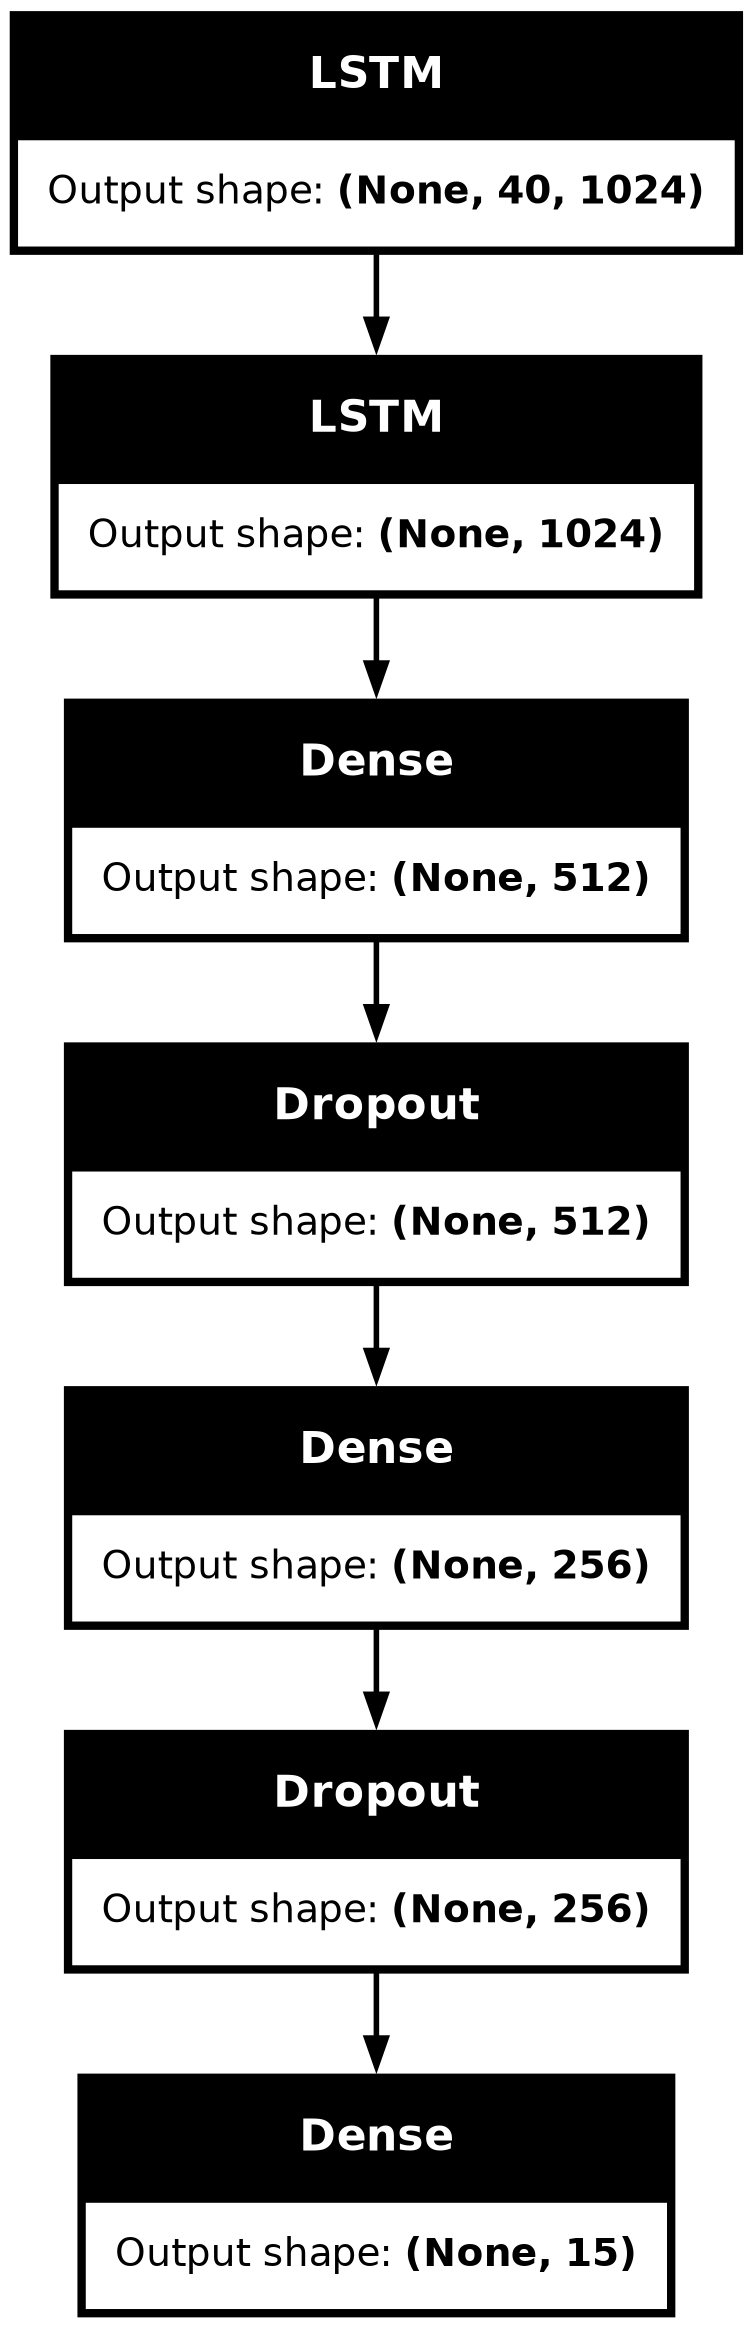

In [161]:
keras.utils.plot_model(lstm_model, 'multi_input_and_output_model.png', show_shapes=True)

In [156]:
val_accuracy = np.mean(history.history['accuracy'])
print("\n%s: %.2f%%" % ('accuracy', np.mean(history.history['accuracy'])*100))


accuracy: 87.61%


Text(0, 0.5, 'Accuracy')

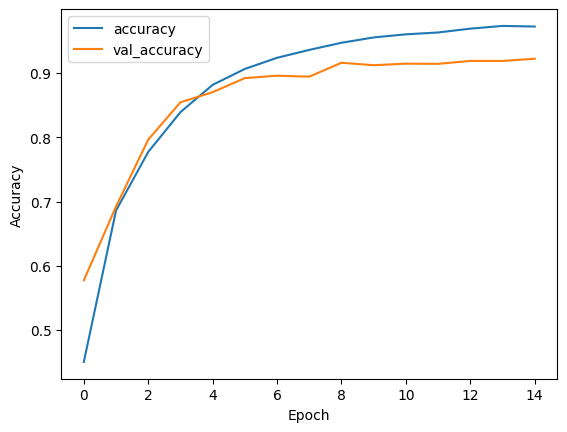

In [157]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [158]:
m =pd.DataFrame(lstm_model.predict(X_valid)).T.idxmax()

424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


In [159]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, m))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       933
           1       0.89      0.86      0.88       873
           2       0.86      0.89      0.87       876
           3       0.95      0.93      0.94       900
           4       0.89      0.88      0.89       819
           5       0.92      0.93      0.93       922
           6       0.94      0.92      0.93       912
           7       0.96      0.95      0.95       912
           8       0.92      0.93      0.93       902
           9       0.93      0.96      0.94       960
          10       0.89      0.93      0.91       888
          11       0.94      0.95      0.95       882
          12       0.96      0.98      0.97       908
          13       0.98      0.97      0.98       906
          14       0.99      0.99      0.99       954

    accuracy                           0.92     13547
   macro avg       0.92      0.92      0.92     13547
weighted avg       0.92   

In [160]:
m =pd.DataFrame(lstm_model.predict(df_test[X_train.columns])).T.idxmax()
print(classification_report( df_test['diagnostic'], m))

918/918 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      9025
           1       0.88      0.85      0.86      2506
           2       0.87      0.87      0.87      2451
           3       0.94      0.92      0.93      2092
           4       0.88      0.88      0.88      2045
           5       0.88      0.92      0.90      2010
           6       0.90      0.90      0.90      1972
           7       0.88      0.93      0.90      1278
           8       0.83      0.85      0.84      1168
           9       0.85      0.93      0.89      1154
          10       0.79      0.88      0.83      1121
          11       0.83      0.90      0.86      1017
          12       0.85      0.94      0.89       594
          13       0.91      0.82      0.86       521
          14       0.88      0.96      0.92       419

    accuracy                           0.89     29373
   macro avg       0.87      0.90    

In [63]:
import keras
model.save('lstm_model_d.keras')

In [ ]:
lstm_model.save('lstm_model_d.h5')
lstm_model.save('lstm_model_d.keras')